In [2]:
#Referencias utiles:
#https://www.ritchieng.com/pandas-apply/
#http://queirozf.com/entries/pandas-dataframe-examples-column-operations
#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_datetime.html
#https://2.python-requests.org/en/master/user/quickstart/#make-a-request (Sección "Response Content")

In [137]:
import urllib3
import re
import requests
import nltk
import os
import string
import csv
import collections
from bs4 import BeautifulSoup
from nltk.tokenize import sent_tokenize,word_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from string import punctuation
from collections import defaultdict
from heapq import nlargest
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

http = urllib3.PoolManager()

In [107]:
#1) Procesar el archivo "cine_center_cartelera.html" para extraer datos y guardarlos en un archivo CSV (cartelera.csv)
# Cada linea de en el archivo deberá contener los siguientes datos
# Nombre
# Duración
# Duración en minutos
# Clasificacion (Apta para todo el público, Mayores de 14 años)
# Audio (DOBLADA, SUBTITULADA)
# Horario (Ex 07:15 pm)
# Nota aclaratria: incluir un print() que muestra la cantidad de filas recuperadas

In [182]:
def obtener_peliculas_comom_componente(pagina):
    return pagina.find_all(name='div', class_='theater-movies__item' )

def obtener_titulo(pelicula):
    return pelicula.find(name='h3', class_='movie-info__title').text.strip()

def obtener_componente_info_basis(pelicula):
    return [i for i in pelicula.find(name='div', class_='movie-info__basic').find_all(name='div')]
#2 Empleando pandas, abra el archivo cartelera.csv y muestre un grafico de barras para cada uno 
# de los siguientes conteos (OPCIONAL)
# Duracion: menor o igual a 90 mins, mayor a 90 mins
# Clasificacion: Apta para todo el público, Mayores de 14 años
# Audio: DOBLADA, SUBTITULADA
# Horario: vespertina, nocturna (considere como nocturna cualquier horario despues de laS 7.00 pm)

def obtener_clasificacion(pelicula):
    info_basis = obtener_componente_info_basis(pelicula)
    return info_basis[0].text.strip()

def obtener_duracion(pelicula):
    info_basis = obtener_componente_info_basis(pelicula)
    return info_basis[1].text.strip()

def obtener_horas(duracion):
    return int(duracion.split()[0].replace('h', ''))
    
def obtener_minutos(duracion):
    return int(duracion.split()[1].replace('m', ''))
    
def calcular_duracion_en_minutos(duracion):
    horas = obtener_horas(duracion)
    minutos = obtener_minutos(duracion)
    return horas*60 + minutos
    
def obtener_audio(pelicula):
    return pelicula.find(name='h4', class_='time__exhibit-mode').text.split()[1].strip()

def obtener_horarios(pelicula):
    horarios = [horario.text for horario in pelicula.find(name='div', class_='time__dates').find_all(name='a')]
    horarios_string = ''.join(horarios)
    return horarios_string

def formatear_pelicula(pelicula):
    nombre = obtener_titulo(pelicula)
    duracion = obtener_duracion(pelicula)
    duracion_en_minutos = calcular_duracion_en_minutos(duracion)
    clasificacion = obtener_clasificacion(pelicula)
    audio = obtener_audio(pelicula)
    horarios = obtener_horarios(pelicula)
    
    return dict(nombre = nombre,
                duracion = duracion,
                duracion_en_minutos = duracion_en_minutos,
                clasificacion = clasificacion,
                audio = audio,
                horarios = horarios)
    
def obtener_peliculas_como_lista_diccionario(peliculas_componente):
    peliculas_con_formato = []
    for pelicula in peliculas_componente:
        peliculas_con_formato.append(formatear_pelicula(pelicula))
    return peliculas_con_formato

def guardar_como_csv(lista_peliculas):
    with open('peliculas.csv', "w", encoding="utf-8", newline="") as output_file:
        dict_writer = csv.DictWriter(output_file, fieldnames=lista_peliculas[0].keys())
        dict_writer.writeheader()
        dict_writer.writerows(lista_peliculas)

In [183]:
respuesta = requests.get('http://localhost:3000/')
pagina = BeautifulSoup(respuesta.text, 'html.parser')
peliculas = obtener_peliculas_comom_componente(pagina)
peliculas_lista_de_diccionarios = obtener_peliculas_como_lista_diccionario(peliculas)
guardar_como_csv(peliculas_lista_de_diccionarios)

In [184]:
#2 Empleando pandas, abra el archivo cartelera.csv y muestre un grafico de barras para cada uno 
# de los siguientes conteos (OPCIONAL)
# Duracion: menor o igual a 90 mins, mayor a 90 mins
# Clasificacion: Apta para todo el público, Mayores de 14 años
# Audio: DOBLADA, SUBTITULADA
# Horario: vespertina, nocturna (considere como nocturna cualquier horario despues de laS 7.00 pm)

                                            nombre duracion  \
0                            Presidente bajo fuego   1h 52m   
1                                  Mejor que nunca   1h 31m   
2                              Traición y venganza   1h 34m   
3                                      Ouija House   1h 35m   
4                                     ¡Asu Mare 3!   1h 42m   
5                                               IT   2h 15m   
6                                      El Rey León   1h 57m   
7   Historias de Miedo para Contar en la Oscuridad    2h 0m   
8                 Rápidos y Furiosos: Hobbs & Shaw   2h 15m   
9                                    Angry Birds 2   1h 36m   
10                                   Tu me manques   1h 45m   
11                           He matado a mi marido   1h 48m   
12                         Infierno en la tormenta   1h 27m   

    duracion_en_minutos              clasificacion        audio  \
0                   112  Apta para todo el público

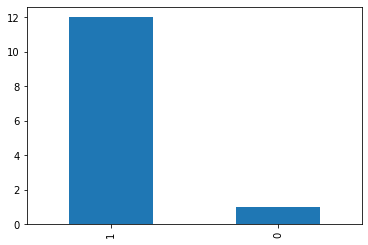

In [185]:
file_path = os.path.join('peliculas.csv')
data = pd.read_csv(file_path)
data['duracion_es_mayor']=(data['duracion_en_minutos']>90).astype(int)
print(data)
# Duracion: menor o igual a 90 mins, mayor a 90 mins
data['duracion_es_mayor'].value_counts().plot.bar()

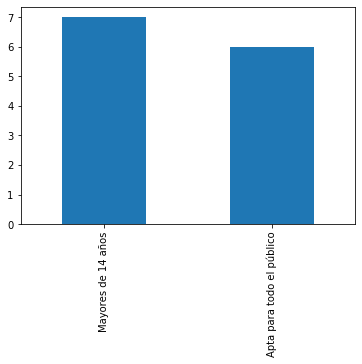

In [186]:
# Clasificacion: Apta para todo el público, Mayores de 14 años
data['clasificacion'].value_counts().plot.bar()

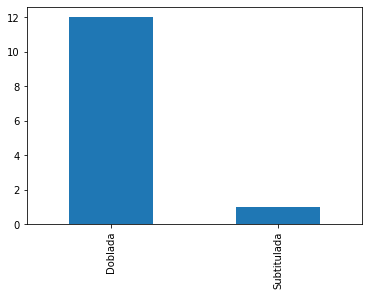

In [187]:
# Audio: DOBLADA, SUBTITULADA
data['audio'].value_counts().plot.bar()